In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, DMatrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier

## Import  

In [2]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')
full = [train, test]

## Missing Value 

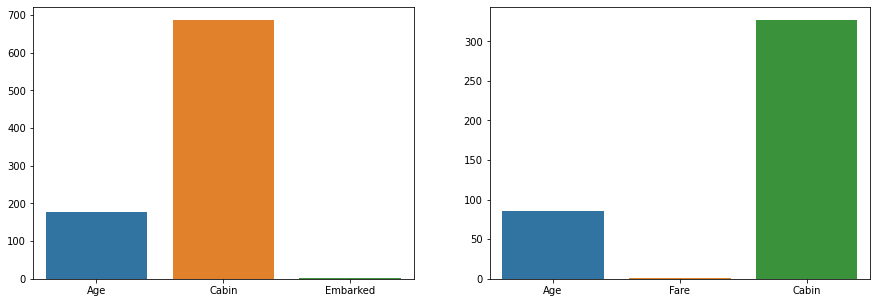

In [3]:
null_train = train.isnull().sum()[train.isnull().sum()>0]
null_test = test.isnull().sum()[test.isnull().sum()>0]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=null_train.index, y=null_train)
plt.subplot(1,2,2)
sns.barplot(x=null_test.index, y=null_test)
plt.show()

In [4]:
#Filling Age
train['Age'] = train.Age.fillna(train.Age.mean())
test['Age'] = test.Age.fillna(train.Age.mean())

#Filling Cabin
train['Cabin'] = train['Cabin'].fillna(0)
test['Cabin'] = test['Cabin'].fillna(0)

#Filling Embarked
train.loc[train.Embarked.isna(),'Embarked'] = train.Embarked.mode()[0]
# train['Embarked'] = train.Embarked.apply(lambda x : train.Embarked.mode()[0] if isinstance(x, float) else x)

#Filling Fare (Test)
test.loc[test.Fare.isna(),'Fare'] = train.Fare.mean()

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


## Feature Engineering 
#### 1. Simplify Sex, Embarked Feature and Cabin

In [6]:
for i in full:
    #Sex, Male:0, Female:1
    i['Sex'] = i.Sex.replace(dict(male=0, female=1))
    
    #Embarked, S:0, C:1, Q:2
    i['Embarked'] = i.Embarked.replace(dict(S=0, C=1, Q=2))
    
    #Cabin, 0:0, str:1
    i['HasCabin'] = i.Cabin.apply(lambda x : 1 if isinstance(x, str) else 0)

#### 2. Binning Age and Fare

In [7]:
for i in full:
    #Age
    i.loc[i['Age'] <= 2, 'Age'] = 0
    i.loc[(i['Age'] > 2) & (i['Age'] <= 16), 'Age'] = 1
    i.loc[(i['Age'] > 16) & (i['Age'] <= 60), 'Age'] = 2
    i.loc[(i['Age'] > 60), 'Age'] = 3
 
    #Fare
    i.loc[(i['Fare']<= 8), 'Fare'] = 0
    i.loc[(i['Fare'] > 8) & (i['Fare'] <= 14.5), 'Fare'] = 1
    i.loc[(i['Fare'] > 14.5) & (i['Fare'] <= 31), 'Fare'] = 2
    i.loc[i['Fare'] >31, 'Fare'] = 3

#### 3. Extracting Prefix and Ticket Type

In [8]:
def prefix(name):
    prefix_search = re.search(' ([A-Za-z]+)\.', name)
    if prefix_search:
        return prefix_search.group(1)
    return ""

In [9]:
for i in full:
    #Extract Prefix
    i['Prefix'] = i.Name.apply(prefix)
    
    i['Prefix'] = i.Prefix.replace(dict(Mr=1,
                                        Miss=2, Mme=2, Ms=2,
                                        Mrs=3, 
                                        Master=4,
                                        Don=5, Rev=5, Major=5, Lady=5, Sir=5, Millie=5, Col=5, Capt=5,
                                        Countess=5, Jonkheer=5, Dr=5, Mlle=5, Dona=5))
#     #Extract Ticket Type
#     i['Ticket_type'] = i['Ticket'].apply(lambda x: x[0:3])
#     i['Ticket_type'] = i['Ticket_type'].astype('category')
#     i['Ticket_type'] = i['Ticket_type'].cat.codes

#### 4. Creating New Features

In [10]:
for i in full:
    #Family Size
    i['FamilySize'] = i['SibSp'] + i['Parch'] + 1

    #Alone
    i['Alone'] = 0
    i.loc[i['FamilySize'] ==1, 'Alone'] = 1

In [11]:
y = train['Survived']
df_train = train.drop(columns='Survived')

drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_train = df_train.drop(columns=drop)
df_test = test.drop(columns=drop)

In [12]:
# for col in ['Sex', 'HasCabin', 'Embarked']:
#     df_train[col] = df_train[col].astype('category')
#     df_test[col] = df_test[col].astype('category')

for col in ['Age', 'Fare']:
    df_train[col] = df_train[col].astype('int64')
    df_test[col] = df_test[col].astype('int64')

for col in ['SibSp', 'Parch']:
    df_train = df_train.drop(columns=col)
    df_test = df_test.drop(columns=col)

In [13]:
df_train.dtypes

Pclass        int64
Sex           int64
Age           int64
Fare          int64
Embarked      int64
HasCabin      int64
Prefix        int64
FamilySize    int64
Alone         int64
dtype: object

In [23]:
import tensorflow as tf
import keras 
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential

In [30]:
model = Sequential()
model.add(Dense(units = 128, input_shape = (9,), activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(units = 256, activation = 'relu', kernel_initializer = 'he_normal', use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(units = 128, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dropout(0.1))
model.add(Dense(units = 64, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dropout(0.1))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 8, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dense(units =1 , activation = 'sigmoid'))

In [31]:
model.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = tf.keras.optimizers.Adam(), metrics = ['acc'])
model.fit(df_train, y, batch_size = 32, verbose = 2, epochs = 50)

Epoch 1/50
28/28 - 1s - loss: 0.5599 - acc: 0.7059
Epoch 2/50
28/28 - 0s - loss: 0.4443 - acc: 0.8204
Epoch 3/50
28/28 - 0s - loss: 0.4344 - acc: 0.8215
Epoch 4/50
28/28 - 0s - loss: 0.4231 - acc: 0.8305
Epoch 5/50
28/28 - 0s - loss: 0.4035 - acc: 0.8260
Epoch 6/50
28/28 - 0s - loss: 0.3940 - acc: 0.8339
Epoch 7/50
28/28 - 0s - loss: 0.3966 - acc: 0.8350
Epoch 8/50
28/28 - 0s - loss: 0.3799 - acc: 0.8541
Epoch 9/50
28/28 - 0s - loss: 0.3798 - acc: 0.8519
Epoch 10/50
28/28 - 0s - loss: 0.3697 - acc: 0.8507
Epoch 11/50
28/28 - 0s - loss: 0.3815 - acc: 0.8294
Epoch 12/50
28/28 - 0s - loss: 0.3748 - acc: 0.8541
Epoch 13/50
28/28 - 0s - loss: 0.3810 - acc: 0.8530
Epoch 14/50
28/28 - 0s - loss: 0.3830 - acc: 0.8496
Epoch 15/50
28/28 - 0s - loss: 0.3617 - acc: 0.8608
Epoch 16/50
28/28 - 0s - loss: 0.3633 - acc: 0.8418
Epoch 17/50
28/28 - 0s - loss: 0.3474 - acc: 0.8631
Epoch 18/50
28/28 - 0s - loss: 0.3632 - acc: 0.8519
Epoch 19/50
28/28 - 0s - loss: 0.3551 - acc: 0.8507
Epoch 20/50
28/28 - 0

In [32]:
predict = model.predict(df_test)
#since we have use sigmoid activation function in output layer
predict = (predict > 0.5).astype(int).ravel()
print(predict)

[0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0
 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0
 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 1 0 1 0 0 1]


In [35]:
submit = pd.DataFrame({"PassengerId":pd.read_csv('../test.csv').PassengerId, 'Survived':predict})
submit.to_csv("submission_v8.csv",index = False)

In [34]:
from sklearn import metrics
Y_pred_rand = (model.predict(df_train) > 0.5).astype(int)
print('Precision : ', np.round(metrics.precision_score(y, Y_pred_rand)*100,2))
print('Accuracy : ', np.round(metrics.accuracy_score(y, Y_pred_rand)*100,2))
print('Recall : ', np.round(metrics.recall_score(y, Y_pred_rand)*100,2))
print('F1 score : ', np.round(metrics.f1_score(y, Y_pred_rand)*100,2))
print('AUC : ', np.round(metrics.roc_auc_score(y, Y_pred_rand)*100,2))

Precision :  83.48
Accuracy :  87.54
Recall :  84.21
F1 score :  83.84
AUC :  86.91


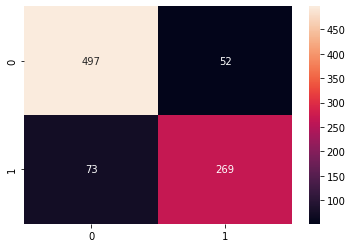

In [29]:
# plotting the confusion matrix in heatmap
matrix = metrics.confusion_matrix(y, Y_pred_rand)
sns.heatmap(matrix, annot = True,fmt = 'g')
plt.show()